In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
import math
from qiskit import QuantumCircuit, Aer, assemble
from math import pi
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector
def calculate_theta(x1, x2):
    x1_a, x1_b = x1
    x2_a, x2_b = x2

    theta1 = math.atan(x1_b / x1_a) * 2
    theta2 = math.atan(x2_b / x2_a) * 2
    
    return theta1, theta2
    
    
theta1, theta2 = calculate_theta((0.9872, 0.1595),(0.3544, 0.9351))

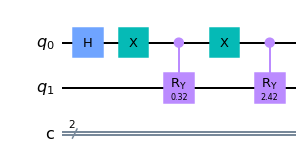

In [3]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.x(0)
qc.cry(theta1,0,1)
qc.x(0)
qc.cry(theta2,0,1)


# qc.measure(0,0)
qc.draw()



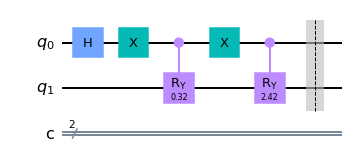

In [4]:
# Add snapshot
from qiskit.providers.aer import extensions
from qiskit import execute
qc.snapshot_density_matrix('density_matrix')

# result = execute(qc, Aer.get_backend('qasm_simulator')).result()
# # Extract density matrix snapshot from result object:
# density_matrix = result.data()['snapshots']['density_matrix']['density_matrix'][0]['value']
# print(density_matrix)

qc.draw()

In [5]:
from qiskit import QuantumRegister
import qiskit.quantum_info as qi

import numpy as np
import time
from copy import deepcopy

# Import Qiskit classes
import qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.compiler import assemble

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Auxiliary methods
from qiskit.quantum_info import Choi, Kraus
from qiskit.extensions import HGate, XGate

# Getting kernel from 2-Qubit state tomography technique
# https://qiskit.org/documentation/tutorials/noise/8_tomography.html

# Create the expected statevector
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.x(q2[0])
bell.cry(theta1,q2[0],q2[1])
bell.x(q2[0])
bell.cry(theta2,q2[0],q2[1])


print(bell)

target_state_bell = qi.Statevector.from_instruction(bell)
print(target_state_bell)


      ┌───┐┌───┐               ┌───┐              
q0_0: ┤ H ├┤ X ├───────■───────┤ X ├──────■───────
      └───┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q0_1: ──────────┤ RY(0.32037) ├─────┤ RY(2.4171) ├
                └─────────────┘     └────────────┘
Statevector([0.69805439+0.j, 0.25059722+0.j, 0.1127833 +0.j,
             0.66121179+0.j],
            dims=(2, 2))


In [6]:
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import Statevector


#print(density_matrix)
statevec = Statevector.from_instruction(bell)
#print(statevec)
trace = partial_trace(statevec, [1])
print(trace)

DensityMatrix([[0.5       +0.j, 0.24950414+0.j],
               [0.24950414+0.j, 0.5       +0.j]],
              dims=(2,))


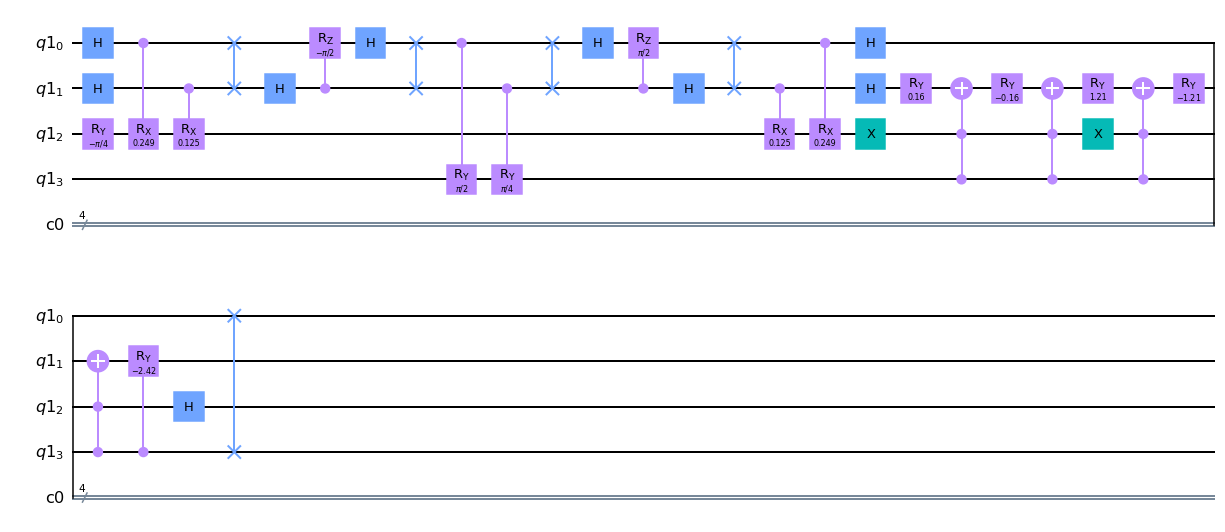

In [7]:
# Work with my Kernel matrix
qreg = QuantumRegister(4)
creg = ClassicalRegister(4)

qsvm_circuit =  QuantumCircuit(qreg, creg)

# Matrix inversion
qsvm_circuit.h(qreg[0])
qsvm_circuit.h(qreg[1])
qsvm_circuit.ry(-math.pi/4, qreg[2])
qsvm_circuit.crx(0.2495, qreg[0], qreg[2])
qsvm_circuit.crx(0.12475, qreg[1],qreg[2])
qsvm_circuit.swap(qreg[0], qreg[1])
qsvm_circuit.h(qreg[1])

qsvm_circuit.crz(-math.pi/2,qreg[1],qreg[0])
qsvm_circuit.h(qreg[0])
qsvm_circuit.swap(qreg[0],qreg[1])
qsvm_circuit.cry(math.pi/2,qreg[0],qreg[3])
qsvm_circuit.cry(math.pi/4,qreg[1],qreg[3])
qsvm_circuit.swap(qreg[0],qreg[1])
qsvm_circuit.h(qreg[0])
qsvm_circuit.crz(math.pi/2,qreg[1],qreg[0])
qsvm_circuit.h(qreg[1])
qsvm_circuit.swap(qreg[0],qreg[1])
qsvm_circuit.crx(0.12475, qreg[1], qreg[2])
qsvm_circuit.crx(0.2495, qreg[0], qreg[2])
qsvm_circuit.h(qreg[0])
qsvm_circuit.h(qreg[1])

# Training-data Oracle
qsvm_circuit.x(qreg[2])
qsvm_circuit.mcry(0.3203,[qreg[2], qreg[3]],qreg[1])
qsvm_circuit.x(qreg[2])
qsvm_circuit.mcry(2.417,[qreg[2], qreg[3]],qreg[1])

# U x0
qsvm_circuit.cry(-2.417, qreg[3], qreg[1]) # change input x here
qsvm_circuit.h(qreg[2])

qsvm_circuit.swap(qreg[0],qreg[3])

qsvm_circuit.draw()

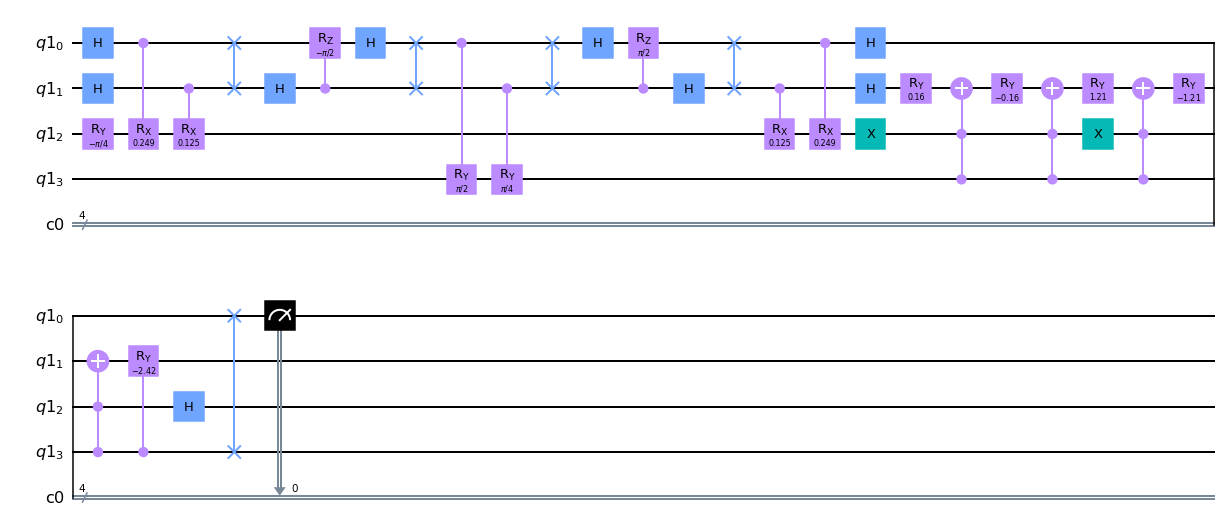

In [8]:
qsvm_circuit.measure(0,0)
qsvm_circuit.draw()

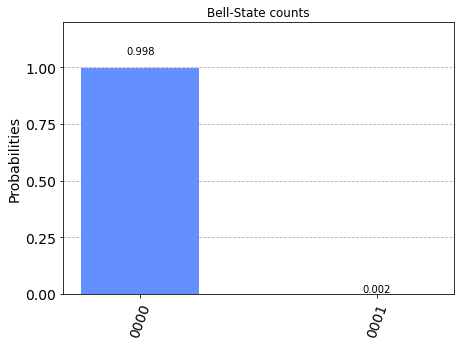

In [9]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qsvm_circuit, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [10]:
print(counts)

{'0001': 2, '0000': 1022}


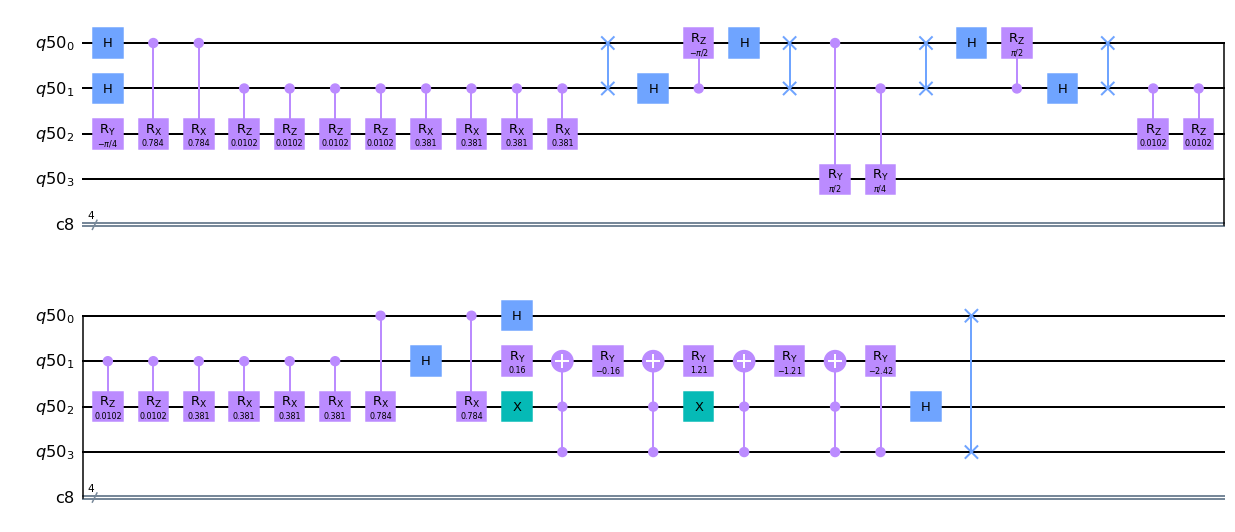

In [22]:
# Work with Kernel matrix in the paper
qreg = QuantumRegister(4)
creg = ClassicalRegister(4)

qsvm_circuit =  QuantumCircuit(qreg, creg)

# Matrix inversion
qsvm_circuit.h(qreg[0])
qsvm_circuit.h(qreg[1])
qsvm_circuit.ry(-math.pi/4, qreg[2])

qsvm_circuit.crx(0.7838, qreg[0], qreg[2]) # exp(iFt0/2)
qsvm_circuit.crx(0.7838, qreg[0], qreg[2]) 
qsvm_circuit.crz(0.0102, qreg[1],qreg[2]) # exp(iFt0/4)
qsvm_circuit.crz(0.0102, qreg[1],qreg[2])
qsvm_circuit.crz(0.0102, qreg[1],qreg[2])
qsvm_circuit.crz(0.0102, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])

qsvm_circuit.swap(qreg[0], qreg[1])
qsvm_circuit.h(qreg[1])

qsvm_circuit.crz(-math.pi/2,qreg[1],qreg[0])
qsvm_circuit.h(qreg[0])
qsvm_circuit.swap(qreg[0],qreg[1])
qsvm_circuit.cry(math.pi/2,qreg[0],qreg[3])
qsvm_circuit.cry(math.pi/4,qreg[1],qreg[3])
qsvm_circuit.swap(qreg[0],qreg[1])
qsvm_circuit.h(qreg[0])
qsvm_circuit.crz(math.pi/2,qreg[1],qreg[0])
qsvm_circuit.h(qreg[1])
qsvm_circuit.swap(qreg[0],qreg[1])


qsvm_circuit.crz(0.0102, qreg[1],qreg[2]) # exp(iFt0/4)
qsvm_circuit.crz(0.0102, qreg[1],qreg[2])
qsvm_circuit.crz(0.0102, qreg[1],qreg[2])
qsvm_circuit.crz(0.0102, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])
qsvm_circuit.crx(0.3809, qreg[1],qreg[2])
qsvm_circuit.crx(0.7838, qreg[0], qreg[2]) # exp(iFt0/2)
qsvm_circuit.crx(0.7838, qreg[0], qreg[2]) 

qsvm_circuit.h(qreg[0])
qsvm_circuit.h(qreg[1])

# Training-data Oracle
qsvm_circuit.x(qreg[2])
qsvm_circuit.mcry(0.3203,[qreg[2], qreg[3]],qreg[1])
qsvm_circuit.x(qreg[2])
qsvm_circuit.mcry(2.417,[qreg[2], qreg[3]],qreg[1])

# U x0
qsvm_circuit.cry(-2.417, qreg[3], qreg[1]) # change input x here (-2.417 or -0.3203)
qsvm_circuit.h(qreg[2])

qsvm_circuit.swap(qreg[0],qreg[3])

qsvm_circuit.draw()

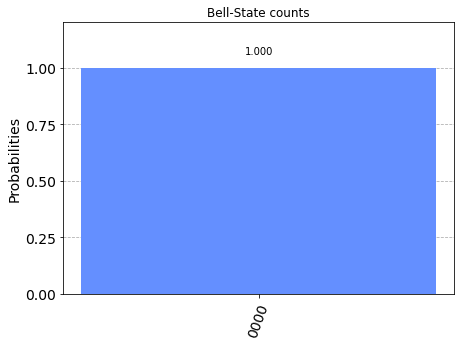

In [23]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qsvm_circuit, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [24]:
print(counts)

{'0000': 1024}


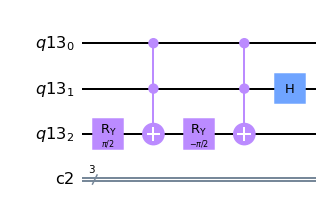

In [90]:
# qreg = QuantumRegister(3)
# creg = ClassicalRegister(3)

# test = QuantumCircuit(qreg,creg)
# test.mcry(math.pi,[qreg[0], qreg[1]],qreg[2])
# test.h(qreg[1])
# test.draw()

In [19]:

# F = trace + [[1/2, 0],[0, 1/2]]

# t = math.pi
# print(F)
# print(t)
# power_e = complex(0, F * t)
# print(power_e)

# from scipy.linalg import expm, sinm, cosm
# a = np.array([[1.0065, 0.2425], [0.2425, 0.9935]])
# print(expm(1j*a))


DensityMatrix([[1.        +0.j, 0.24950414+0.j],
               [0.24950414+0.j, 1.        +0.j]],
              dims=(2,))
3.141592653589793
[[ 0.51906605+0.82031014j -0.20206119+0.129742j  ]
 [-0.20206119+0.129742j    0.5298982 +0.8133549j ]]


In [33]:
t = time.time()

# Generate the state tomography circuits.
qst_bell = state_tomography_circuits(bell, [q2[0],q2[1]])


# Execute
job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)
print('Time taken:', time.time() - t)

# Fit result
tomo_fitter_bell = StateTomographyFitter(job.result(), qst_bell)

Time taken: 0.28522181510925293


In [34]:
# Perform the tomography fit
# which outputs a density matrix
rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
print("rho_fit_bell:")
print(rho_fit_bell)
print("target_state_bell:")
print(target_state_bell)
F_bell = qi.state_fidelity(rho_fit_bell, target_state_bell)
print("F_bell:")
print(F_bell)
print('State Fidelity: F = {:.5f}'.format(F_bell))


# [[0.6980, 0.2506],
# [0.1128, 0.6612]]
#1.3592
#[[0.5135, 0.1844],
#[0.0830, 0.4865]]

rho_fit_bell:
[[0.48503665+0.j         0.17925486-0.00592129j 0.07573549+0.00298731j
  0.4555511 +0.0073922j ]
 [0.17925486+0.00592129j 0.06792497+0.j         0.02907439+0.00387568j
  0.16624584+0.00660775j]
 [0.07573549-0.00298731j 0.02907439-0.00387568j 0.0147522 +0.j
  0.06782584-0.00050262j]
 [0.4555511 -0.0073922j  0.16624584-0.00660775j 0.06782584+0.00050262j
  0.43228618+0.j        ]]
target_state_bell:
Statevector([0.69805439+0.j, 0.25059722+0.j, 0.1127833 +0.j,
             0.66121179+0.j],
            dims=(2, 2))
F_bell:
0.9918199053472543
State Fidelity: F = 0.99182


In [6]:
usim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
unitary = usim.run(qobj).result().get_unitary()


qobj = assemble(qc)
result = svsim.run(qobj).result()

final_state = result.get_statevector()
plot_histogram(result.get_counts())

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] AerSimulator: circuit with instructions {"instructions": {gate}, "gates": {cry, h, x}} is not compatible with any of the automatic simulation methods


Traceback (most recent call last):
  File "<ipython-input-6-87d1a1d381d9>", line 3, in <module>
    unitary = usim.run(qobj).result().get_unitary()
  File "/opt/conda/lib/python3.8/site-packages/qiskit/result/result.py", line 327, in get_unitary
    return postprocess.format_unitary(self.data(experiment)['unitary'],
  File "/opt/conda/lib/python3.8/site-packages/qiskit/result/result.py", line 181, in data
    return self._get_experiment(experiment).data.to_dict()
  File "/opt/conda/lib/python3.8/site-packages/qiskit/result/result.py", line 387, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
QiskitError: 'ERROR:  [Experiment 0] AerSimulator: circuit with instructions {"instructions": {gate}, "gates": {cry, h, x}} is not compatible with any of the automatic simulation methods ,  ERROR: AerSimulator: circuit with instructions {"instructions": {gate}, "gates": {cry, h, x}} is not compatible with any of the automatic simulation methods'

Use %tb to get the full tr